# 1. Загрузка библиотек и базовые настройки

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats

from matplotlib import pyplot as plt
from matplotlib import image as img
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

import warnings
warnings.filterwarnings('ignore')

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.metrics import mean_squared_error as mse, r2_score as r2
from sklearn.ensemble import RandomForestRegressor

# 2. Задание функции для валидации модели

In [2]:
def evaluate_preds(train_true_values, train_pred_values, test_true_values, test_pred_values):
    print("Train R2:\t" + str(round(r2(train_true_values, train_pred_values), 3)))
    print("Test R2:\t" + str(round(r2(test_true_values, test_pred_values), 3)))
    
    plt.figure(figsize=(12, 10))
    
    plt.subplot(121)
    sns.scatterplot(x=train_pred_values, y=train_true_values)
    plt.plot([0, 650000], [0, 650000], linestyle='--', color='black')
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Train sample prediction')
    
    plt.subplot(122)
    sns.scatterplot(x=test_pred_values, y=test_true_values)
    plt.plot([0, 650000], [0, 650000], linestyle='--', color='black')
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Test sample prediction')

    plt.show()

# 3. Загрузка датасетов

In [3]:
train_df = pd.read_csv('./train.csv', sep=',')
test_df = pd.read_csv('./test.csv', sep=',')

# 4. Создание класса для обработки данных

In [4]:
class Data:
    
    def __init__(self):
        self.Price = None
        self.medians = None
        self.mode_Rooms = None
        self.mode_HouseFloor = None
        self.mode_Floor = None
        self.mode_Social_1 = None
        self.mode_Healthcare_2 = None
        self.mode_Shops_1 = None
        
    # уменьшение занимаемой памяти
    def reduce_mem_usage(self, df):
    
        for col in df.columns:
            col_type = df[col].dtype
            if col_type != object:
                c_min = df[col].min()
                c_max = df[col].max()
                if str(col_type)[:3] == 'int':
                    if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                        df[col] = df[col].astype(np.int8)
                    elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                        df[col] = df[col].astype(np.int16)
                    elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                        df[col] = df[col].astype(np.int32)
                    elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                        df[col] = df[col].astype(np.int64)  
                else:
                    if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                        df[col] = df[col].astype(np.float32)
                    else:
                        df[col] = df[col].astype(np.float64)
            else:
                df[col] = df[col].astype('category')
        return df

    # Изменение формата столбцов и названий   
    def new_fiew(self, df):
        df = df.astype({'HouseFloor': np.int8, 
                        'Rooms': np.int8, 
                        'Social_2': np.float32, 
                        'Social_3': np.float32
                       })
        df.rename(columns = {'DistrictId' : 'District', 
                             'HouseYear' : 'Year', 
                             'Helthcare_2' : 'Healthcare_2'}, 
                  inplace = True)
        return df
    
    # Расчет медиан и мод на тренировочном датасете
    def fit(self, df):
        self.Price = df['Price']
        self.medians = df.median()
        self.mode_Rooms = df['Rooms'].mode()[0]
        self.mode_HouseFloor = df['HouseFloor'].mode()[0]
        self.mode_Floor = df['Floor'].mode()[0]
        self.mode_Social_1 = df['Social_1'].mode()[0]
        self.mode_Healthcare_2 = df['Healthcare_2'].mode()[0]
        self.mode_Shops_1 = df['Shops_1'].mode()[0]
        return df
              
    # Обработка выбросов и пропусков
    def transform(self, df):
        df.loc[(df['Rooms'] > 6) | (df['Rooms'] < 1), 'Rooms'] = self.mode_Rooms
        df.loc[(df['Square'] > 300) | (df['Square'] < 15), 'Square'] = self.medians.Square
        df.loc[(df['KitchenSquare'] > 30) | (df['KitchenSquare'] < 3), 'KitchenSquare'] = self.medians.KitchenSquare
        df.loc[(df['LifeSquare'] > 280) | (df['LifeSquare'] < 10), 'LifeSquare'] = self.medians.LifeSquare
        df.loc[(df['HouseFloor'] > 50) | (df['HouseFloor'] < 1), 'HouseFloor'] = self.mode_HouseFloor
        df.loc[(df['Floor'] > 50) | (df['Floor'] < 1), 'Floor'] = self.mode_Floor
        df.loc[df['Year'] > 2020, 'Year'] = 2020
        df.loc[df['Ecology_1'] == 0, 'Ecology_1'] = self.medians.Ecology_1
        df.loc[df['Social_3'] == 0, 'Social_3'] = self.mode_Floor
        df.loc[df['Social_1'] == 0, 'Social_1'] = self.mode_Social_1
        df.loc[df['Healthcare_2'] == 0, 'Healthcare_2'] = self.mode_Healthcare_2
        df.loc[df['Shops_1'] == 0, 'Shops_1'] = self.mode_Shops_1
        return df
    
    # Генерация новых признаков
    def new_features(self, df):
        df['Floor_altitude'] = (df['Floor'] / df['HouseFloor']).round(decimals=1)
        df.loc[df['Floor_altitude'] > 1, 'Floor_altitude'] = df['Floor_altitude'].median()
        df['IsFirstFloor'] = (df['Floor_altitude'] < 0.2).astype(int)
        
        df['LifeSquare_fraction'] = (1 - df['KitchenSquare'] / df['Square']).round(decimals=3)
        df.loc[df['LifeSquare_fraction'] < 0.7, 'LifeSquare_fraction'] = df['LifeSquare_fraction'].median()
        df['LifeSquare_new'] = df['LifeSquare_fraction'] * df['Square']
        df.loc[df['LifeSquare'] == df['LifeSquare'].median(), 'LifeSquare'] = df['LifeSquare_new']
        df.loc[(df['LifeSquare'].isna()), 'LifeSquare'] = df['LifeSquare_new']
        
        df['Price_per_square'] = self.Price / df['Square'].round(decimals=3)
        df_mean_price_dist = df.groupby('District').median()['Price_per_square'].round()
        df_mean = pd.DataFrame(df_mean_price_dist)
        df_mean.rename(columns = {'Price_per_square' : 'Median_Price_per_square'}, inplace = True)
        df = df.merge(df_mean, on=['District'])
        
        df['Year_expensive'] = 0
        df.loc[df['Year'] <= 1955, 'Year_expensive'] = 10
        df.loc[(df['Year'] > 1995) & (df['Year'] <= 2005), 'Year_expensive'] = 9
        df.loc[(df['Year'] > 1985) & (df['Year'] <= 1995), 'Year_expensive'] = 8
        df.loc[(df['Year'] > 1977) & (df['Year'] <= 1985), 'Year_expensive'] = 7
        df.loc[df['Year'] == 1976, 'Year_expensive'] = 7
        df.loc[(df['Year'] > 1955) & (df['Year'] <= 1965), 'Year_expensive'] = 6
        df.loc[(df['Year'] > 2005) & (df['Year'] <= 2015), 'Year_expensive'] = 5
        df.loc[(df['Year'] > 1970) & (df['Year'] <= 1975), 'Year_expensive'] = 4
        df.loc[df['Year'] > 2015, 'Year_expensive'] = 3
        df.loc[(df['Year'] > 1965) & (df['Year'] <= 1970), 'Year_expensive'] = 2
        df.loc[df['Year'] == 1977, 'Year_expensive'] = 1
        
        df.replace({'Ecology_2': {'A': 0, 'B': 1}}, inplace=True)
        df.replace({'Ecology_3': {'A': 0, 'B': 1}}, inplace=True)
        df.replace({'Shops_2': {'A': 0, 'B': 1}}, inplace=True)

        df.drop(['District', 'Healthcare_1', 
                 'HouseFloor', 'Floor', 'Id', 
                 'Price_per_square', 'Year',
                 'LifeSquare_new', 'LifeSquare_fraction'], inplace=True, axis=1)
        return df
    
    # Нормализация признаков
    def scaler(self, df):
        mms = MinMaxScaler()
        feature_names_for_norm = df[['Ecology_1','Social_1', 'Social_2', 'Social_3', 
                                     'Healthcare_2', 'Shops_1', 'Year_expensive']].columns.tolist()
        mms.fit(df[feature_names_for_norm])
        norm_features_df = mms.transform(df[feature_names_for_norm])
        df[feature_names_for_norm] = norm_features_df
        return df

In [5]:
preprocessor = Data()

# 5. Уменьшение занимаемой памяти и переименование столбцов

In [6]:
train_df = preprocessor.reduce_mem_usage(train_df)
test_df = preprocessor.reduce_mem_usage(test_df)

train_df = preprocessor.new_fiew(train_df)
test_df = preprocessor.new_fiew(test_df)

# 6. EDA тренировочного датасета

## а. Общий вид

In [7]:
train_df.shape

(10000, 20)

In [8]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   Id             10000 non-null  int16   
 1   District       10000 non-null  int16   
 2   Rooms          10000 non-null  int8    
 3   Square         10000 non-null  float32 
 4   LifeSquare     7887 non-null   float32 
 5   KitchenSquare  10000 non-null  float32 
 6   Floor          10000 non-null  int8    
 7   HouseFloor     10000 non-null  int8    
 8   Year           10000 non-null  int32   
 9   Ecology_1      10000 non-null  float32 
 10  Ecology_2      10000 non-null  category
 11  Ecology_3      10000 non-null  category
 12  Social_1       10000 non-null  int8    
 13  Social_2       10000 non-null  float32 
 14  Social_3       10000 non-null  float32 
 15  Healthcare_1   5202 non-null   float32 
 16  Healthcare_2   10000 non-null  int8    
 17  Shops_1        10000 non-null  i

## b. Анализ количественных переменных

In [9]:
train_df.describe()

,Id,District,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,Year,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Healthcare_2,Shops_1,Price
count,10000.00000,10000.000000,10000.000000,10000.000000,7887.000000,10000.000000,10000.000000,10000.000000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,5202.000000,10000.000000,10000.000000,10000.000000
mean,8383.40770,50.400800,1.890500,56.315720,37.199665,6.273300,8.526700,12.609400,3.990166e+03,0.118858,24.687000,5352.140625,8.039200,1142.904419,1.319500,4.231300,214138.937500
std,4859.01902,43.587592,0.839512,21.058716,86.241219,28.560839,5.241148,6.775974,2.005003e+05,0.119025,17.532614,4006.817627,23.831953,1021.519470,1.493601,4.806341,92872.273438
min,0.00000,0.000000,0.000000,1.136859,0.370619,0.000000,1.000000,0.000000,1.910000e+03,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,0.000000,59174.777344
25%,4169.50000,20.000000,1.000000,41.774879,22.769833,1.000000,4.000000,9.000000,1.974000e+03,0.017647,6.000000,1564.000000,0.000000,350.000000,0.000000,1.000000,153872.628906
50%,8394.50000,36.000000,2.000000,52.513309,32.781261,6.000000,7.000000,13.000000,1.977000e+03,0.075424,25.000000,5285.000000,2.000000,900.000000,1.000000,3.000000,192269.648438
75%,12592.50000,75.000000,2.000000,65.900627,45.128803,9.000000,12.000000,17.000000,2.001000e+03,0.195781,36.000000,7227.000000,5.000000,1548.000000,2.000000,6.000000,249135.460938
max,16798.00000,209.000000,19.000000,641.065186,7480.592285,2014.000000,42.000000,117.000000,2.005201e+07,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.000000,23.000000,633233.437500


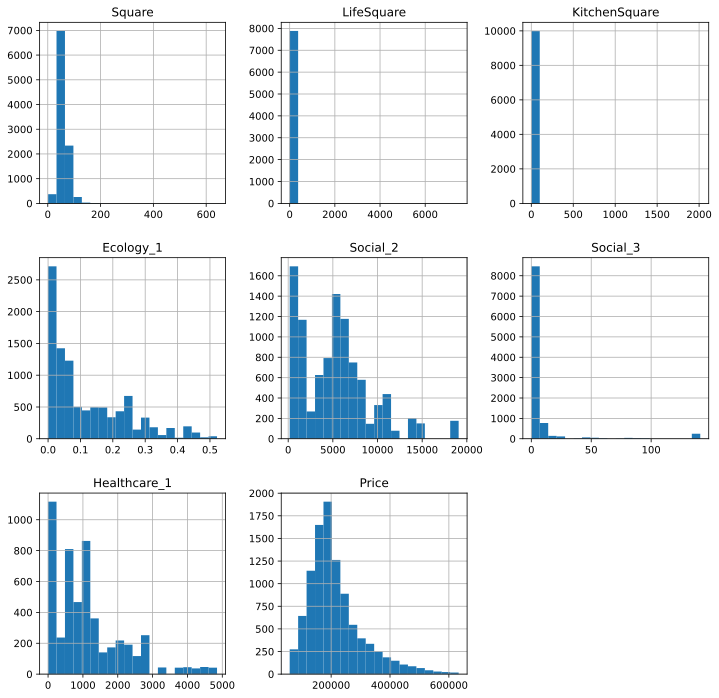

In [10]:
train_df_num_features = train_df.select_dtypes(include=['float64', 'float32', 'float16'])
train_df_num_features.hist(figsize=(12, 12), bins=20, grid=True, layout=(-1, 3));

## b. Анализ номинальных переменных

In [11]:
train_df_cat_features = train_df.select_dtypes(include=['int8', 'int16', 'int32', 'int64', 'category'])
for col in train_df_cat_features:
        un_n = train_df[col].nunique()
        uniqset = np.array(train_df[col].unique())
        print(f'no of unique {col}: {un_n}')
        print(f'{np.sort(uniqset)} \n')

no of unique Id: 10000
[    0     2     5 ... 16796 16797 16798] 

no of unique District: 205
[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 199
 200 201 202 205 207 208 209] 

no of unique Rooms: 9
[ 0  1  2  3  4  5  6 10 19] 

no of unique Floor

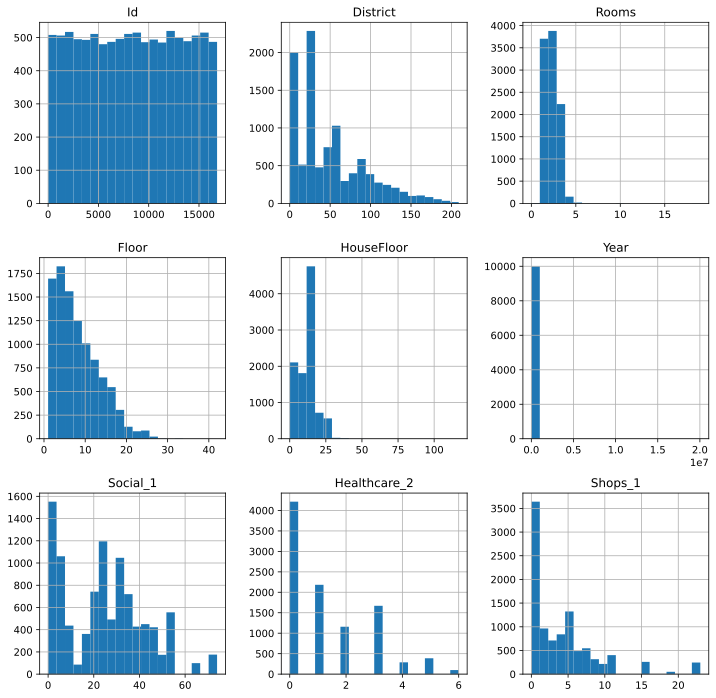

In [12]:
train_df_cat_features.hist(figsize=(12, 12), bins=20, grid=True, layout=(-1, 3));

# 7. Обработка датасетов

In [13]:
preprocessor.fit(train_df)

train_df = preprocessor.transform(train_df)
test_df = preprocessor.transform(test_df)

train_df = preprocessor.new_features(train_df)
test_df = preprocessor.new_features(test_df)

train_df = preprocessor.scaler(train_df)
test_df = preprocessor.scaler(test_df)

# 8. Разделение тренировочного датасета на собственно тренировочный и валидационный

In [14]:
X = train_df.drop(columns='Price')
y = train_df['Price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, shuffle=True, random_state=100)

# 9. Тренировка финальной модели с гиперпараметрами, определенными с помощью GridSearch

In [15]:
final_model = RandomForestRegressor(criterion='mse',
                                    max_depth=7,
                                    min_samples_leaf=6,
                                    random_state=42, 
                                    n_estimators=160
                                   )

final_model.fit(X_train, y_train)

RandomForestRegressor(criterion='mse', max_depth=7, min_samples_leaf=6,
                      n_estimators=160, random_state=42)

# 10. Валидация

Train R2:	0.793
Test R2:	0.745


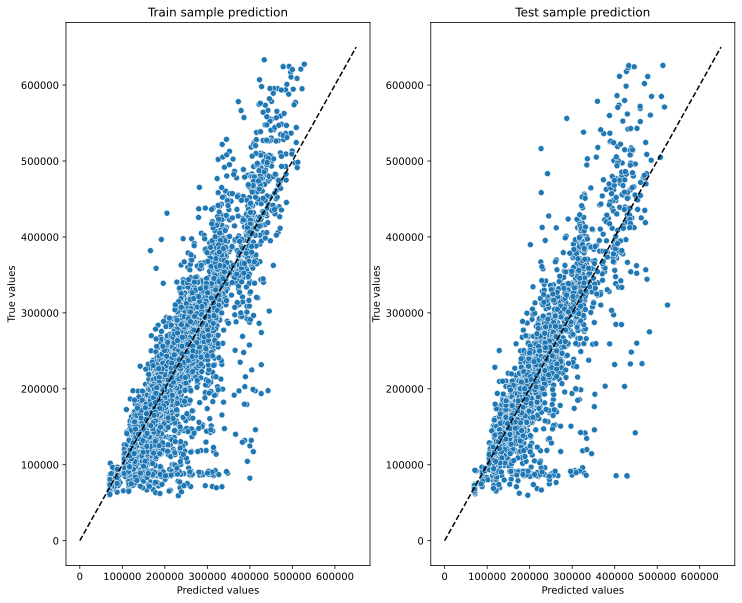

In [16]:
y_train_preds = final_model.predict(X_train)
y_test_preds = final_model.predict(X_test)

evaluate_preds(y_train, y_train_preds, y_test, y_test_preds)

In [17]:
feature_importances = pd.DataFrame(zip(X_train.columns, 
                                       final_model.feature_importances_), 
                                   columns=['feature_name', 'importance'])

feature_importances.sort_values(by='importance', ascending=False, inplace=True)
feature_importances.head()

,feature_name,importance
1,Square,0.516922
15,Median_Price_per_square,0.381735
0,Rooms,0.029411
16,Year_expensive,0.015760
8,Social_2,0.011694


# 11. Загрузка submission и предсказание стоимости недвижимости

In [18]:
submit = pd.read_csv('./sample_submission.csv', sep=',')
predictions = final_model.predict(test_df)
submit['Price'] = predictions
submit.to_csv('AErmak_predictions.csv', index=False)

In [19]:
submit.head(3)

,Id,Price
0,4567,163253.434308
1,5925,236172.497112
2,960,199554.564320
